In [1]:
%matplotlib inline
%config InlineBackend.figure_format = "retina"

from astropy.table import Table
import astropy.units as u
import astropy.constants as c

import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams["font.size"] = 20
rcParams['figure.dpi'] = 100
rcParams["savefig.dpi"] = 300
rcParams["savefig.bbox"] = 'tight'

import numpy as np
import pandas as pd
import pickle

import os
import requests
from io import BytesIO
from io import StringIO

from astropy.table import Table
from astropy.table import join
from astropy.io import ascii
import astropy.constants as c



from scipy import interpolate
from scipy import stats
#from sklearn import svm

# Function to get NASA Exoplanet Archive catalogs 
# from Dan Foreman-Mackey (https://github.com/dfm/exopop)
def get_catalog(name, basepath="../data"):
    fn = os.path.join(basepath, "{0}.h5".format(name))
    if os.path.exists(fn):
        return pd.read_hdf(fn, name)
    if not os.path.exists(basepath):
        os.makedirs(basepath)
    print("Downloading {0}...".format(name))
    url = ("http://exoplanetarchive.ipac.caltech.edu/cgi-bin/nstedAPI/"
           "nph-nstedAPI?table={0}&select=*").format(name)
    r = requests.get(url)
    if r.status_code != requests.codes.ok:
        r.raise_for_status()
        
    fh = BytesIO(r.content)
    df = pd.read_csv(fh)
    df.to_hdf(fn, name, format="t")
    return df

#To track the provenance of different columns, we want a function to prepend an informative string to each column name.
#We will do this before merging tables to make tracking the information easier.
def prepend_dataframe_columns(df, prefix):
    df.columns = [prefix+col for col in df.columns]
    #df.columns = df.columns.str.lower()
    return 

#Suppressing astropy units warnings
import warnings
from astropy.utils.exceptions import AstropyWarning

warnings.filterwarnings('ignore', category=UserWarning, append=True)
warnings.simplefilter('ignore', category=AstropyWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)

#Suppressing Pandas chained assignment warnings
pd.options.mode.chained_assignment = None  # default='warn'

# Set the plot styles

In [2]:
import seaborn as sns
#berry = ['#6797aa', '#7d3f79', '#201e5b', '#dda3d1', '#805da4', '#0c0c0d']
#sns.set_palette(sns.color_palette(berry))
#sns.palplot(sns.color_palette(berry))
#sns.palplot(sns.color_palette("cubehelix", 10))

sns.set(style="ticks", 
        context="paper",
        font_scale=1,
        palette=sns.color_palette("coolwarm"))

sc_kws = {"cmap": "viridis", 
          "s": 10, 
          "rasterized":True, 
          "lw": 0.25, 
          "alpha": 1}

#ebar_kws = {}
#hist_kws = {}

In [3]:
df = pd.read_parquet("./data.parquet")

### Nissen et al. 2020 tables
Define "Sun-like" stars here

In [99]:
nis_t1 = Table.read("http://cdsarc.unistra.fr/ftp/J/A+A/640/A81/table1.dat",
                readme="http://cdsarc.unistra.fr/ftp/J/A+A/640/A81/ReadMe",
                format="ascii.cds")

nis_t2 = Table.read("http://cdsarc.unistra.fr/ftp/J/A+A/640/A81/table2.dat",
                readme="http://cdsarc.unistra.fr/ftp/J/A+A/640/A81/ReadMe",
                format="ascii.cds")

nis = join(nis_t1,nis_t2)

nis['ymg_ratio'] = nis['[Y/Fe]'] - nis['[Mg/Fe]']
nis['yal_ratio'] = nis['[Y/Fe]'] - nis['[Al/Fe]']

# n20_sun_like = (df.cks_Teff>5600)&(df.cks_Teff<5950)&\
#                (df.p20_cks_slogg>4.2)&(df.p20_cks_slogg<4.53)&\
#                (df['cks_[Fe/H]']>-0.3)&(df['cks_[Fe/H]']<0.3) & (df['bf18_S/N']>30)


n20_sun_like = (df['bf18_Teff']>5600)&(df['bf18_Teff']<5950)&\
               (df['bf18_log(g)']>4.2)&(df['bf18_log(g)']<4.53)&\
               (df['bf18_[Fe/H]']>-0.3)&(df['bf18_[Fe/H]']<0.3) #& (df['bf18_S/N']>30)


nis = nis.to_pandas()
nis = nis.replace(9.999, np.nan)

nis.head()

,HD,Teff,logg-sp,Vturb,[Fe/H],[alpha/Fe],Zs,logL,Age,e_Age,...,[Al/Fe],[Si/Fe],[Ca/Fe],[Ti/Fe],[Cr/Fe],[Ni/Fe],[Sr/Fe],[Y/Fe],ymg_ratio,yal_ratio
0,361,5892,4.524,1.05,-0.130,-0.003,0.0135,-0.021,1.5,0.9,...,-0.042,-0.013,0.027,0.019,0.002,-0.056,0.106,0.079,0.093,0.121
1,1461,5760,4.372,1.03,0.190,0.009,0.0275,0.077,5.5,0.5,...,0.044,0.014,-0.016,0.007,0.005,0.045,-0.052,-0.039,-0.046,-0.083
2,2071,5724,4.486,0.96,-0.087,0.013,0.0152,-0.076,4.1,0.9,...,-0.001,0.002,0.024,0.029,0.005,-0.029,0.032,0.039,0.038,0.040
3,4915,5662,4.513,0.93,-0.212,0.042,0.0121,-0.154,3.8,1.3,...,0.020,0.014,0.045,0.064,0.006,-0.037,0.036,0.032,-0.016,0.012
4,6204,5857,4.517,1.05,0.046,-0.038,0.0188,-0.034,-0.4,1.0,...,-0.078,-0.044,0.019,-0.009,0.005,-0.064,0.129,0.122,0.184,0.200


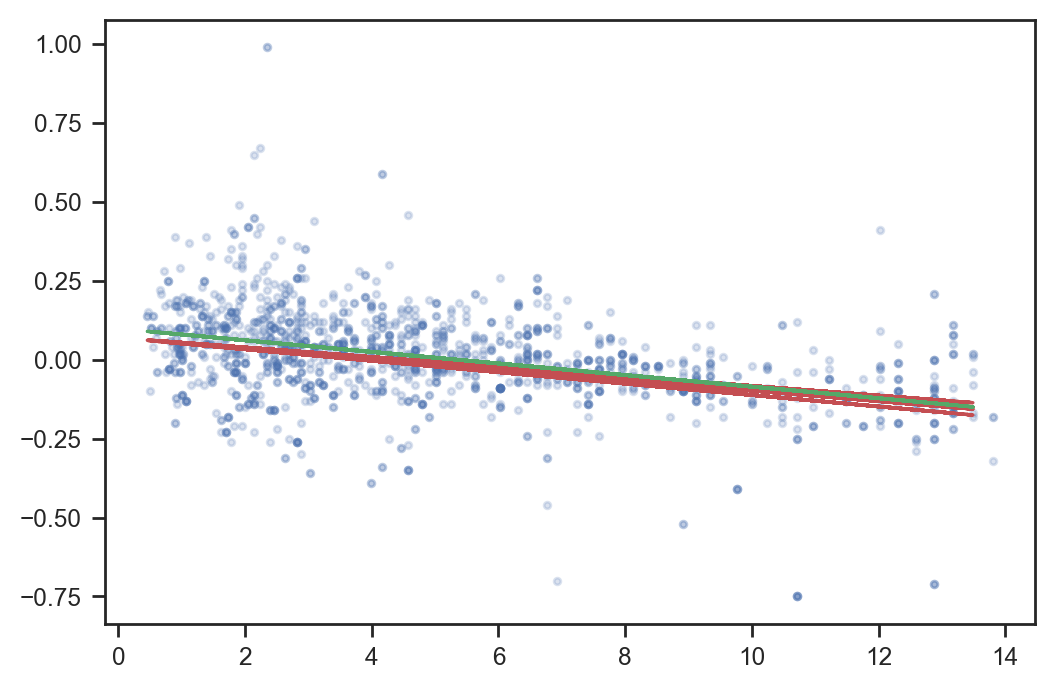

In [37]:
x,y = df['cks_age'], df['bf18_[Y/Mg]']
_ = (np.isfinite(x)) & (np.isfinite(y))

lsq_res = stats.linregress(x[_], y[_])
res = stats.theilslopes(y[_], x[_], 0.90)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(x, y, 'b.', alpha=0.2)
ax.plot(x, res[1] + res[0] * x, 'r-')
ax.plot(x, res[1] + res[2] * x, 'r--')
ax.plot(x, res[1] + res[3] * x, 'r--')
ax.plot(x, lsq_res[1] + lsq_res[0] * x, 'g-')
plt.show()

## Which are the most age-sensitive abundance ratios?

In [151]:
def age_sensitivity_search(age_col='cks', 
                           method='pearson',
                           group='all',
                           plot=False):
    
    teff = df["p20_cks_steff"]
    logg = df["p20_cks_slogg"]
    feh  = df["p20_cks_smet"]
    snr  = df["bf18_S/N"]
    
    n20_sun_like = (teff>5600)&(teff<5950)&\
               (logg>4.2) & (logg<4.53)&\
               (feh>-0.3) & (feh<0.3) #& (df['bf18_S/N']>30)    
    
    
    abcols = []
    taus = []
    pvals = []
    medslopes = []
    medintercepts = []
    lo_slopes = []
    up_slopes = []
    rms = []
    
    if age_col=='cks':
        x = df['cks_age']
        xerr=[df['cks_e_age'],df['cks_E_age']]
    elif age_col=='spocs':
        x = df['bf18_Age']
        xerr = [df['bf18_e_Age'], df['bf18_E_Age']]
    elif age_col=='berger':
        x = df['b20_iso_age']
        xerr = [-df['b20_iso_age_err2'], df['b20_iso_age_err1']]
    elif age_col=='lu':
        x = df['l20_kin_age']
        xerr = 1.8*np.ones(len(x))
        
    
    z = df['bf18_[Fe/H]']    

    for col in df.columns:
        if 'bf18_[' in col:
            
            y = df[col]

            mask = (np.isfinite(x)) & (np.isfinite(y))
            
            if group == 'all':
                pass
            
            elif group == 'sunlike':
                mask &= n20_sun_like

            elif group == 'evolved':
                mask &= (logg<4.1)
            
            elif group == 'hotdwarfs':
                mask &= (logg>=4.1) & (teff>=5500)
                
            elif group == 'cooldwarfs':
                mask &= (logg>=4.2) & (teff<5500)                
            
                

            if method=='pearson':
                tau,pval = stats.pearsonr(x[mask], y[mask])
            elif method=='spearman':
                tau,pval = stats.spearmanr(x[mask], y[mask])
            elif method=='kendall':
                tau,pval = stats.kendalltau(x[mask], y[mask])
            elif method=='theil':
                medslope, medintercept, lo_slope, up_slope = stats.theilslopes(y[mask], x[mask])
                tau,pval = stats.pearsonr(x[mask], y[mask])
            
            if plot==True:
                fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(4,3.5))            

                ax.errorbar(x, y, 
                            xerr=xerr, 
                            fmt='.', ecolor='lightgrey', lw=0.5)

                sc = ax.scatter(x, y, c=z, cmap='viridis', zorder=999, s=6)
                cb = fig.colorbar(sc, ax=ax)

                if pval>0.001:
                    ax.set_title(r'$\rho$ ='+str(np.round(rho,3))+'\n'+"{:.4f}".format(pval))    
                elif pval<0.001:
                    ax.set_title(r'$\rho$ ='+str(np.round(rho,3))+'\n p-value < 0.001')


                ax.set_xlabel('Age [Gyr]')
                ax.set_ylabel(col.split("bf18_")[1])

                ax.set_ylim(-1.5,1.5)
                cb.set_label('[Fe/H]')
                plt.tight_layout()
                plt.savefig('./figures/age-abundance-trends/'+col.split("bf18_[")[1].replace("/","").rstrip("]")+'.pdf')
                plt.close()
            
            
            if method!='theil':
                abcols.append(col)
                taus.append(tau)
                pvals.append(pval)
            
            elif method=='theil':
                abcols.append(col)
                medslopes.append(medslope)
                medintercepts.append(medintercept)
                lo_slopes.append(lo_slope)
                up_slopes.append(up_slope)
                
                model = medintercept + medslope * x[mask]
                resid = (y[mask]-model)
                rms.append(np.sqrt(np.median(resid ** 2)))
                
                #Results from Pearson correlation test
                taus.append(tau)
                pvals.append(pval)                
                
                
    if method!="theil":
        abcols = np.array(abcols)
        taus   = np.array(taus)
        pvals  = np.array(pvals)            
                
        return abcols, taus, pvals

    elif method=="theil":
        
        abcols = np.array(abcols)
        medslopes = np.array(medslopes)
        medintercepts = np.array(medintercepts)
        lo_slopes = np.array(lo_slopes)
        up_slopes = np.array(up_slopes)
        rms = np.array(rms)
        
        taus   = np.array(taus)
        pvals  = np.array(pvals)            
        
        return abcols, taus, pvals, medslopes, medintercepts, lo_slopes, up_slopes, rms
        
# abcols, taus_cks, pvals_cks, medslopes_cks, medintercepts_cks, lo_slopes_cks, up_slopes_cks, rms_cks = age_sensitivity_search(age_col='cks', group='hotdwarfs', method='theil')
# abcols, taus_spocs, pvals_spocs, medslopes_spocs, medintercepts_spocs, lo_slopes_spocs, up_slopes_spocs, rms_spocs = age_sensitivity_search(age_col='spocs', group='hotdwarfs', method='theil')
# abcols, taus_berg, pvals_berg, medslopes_berg, medintercepts_berg, lo_slopes_berg, up_slopes_berg, rms_berg = age_sensitivity_search(age_col='berger', group='hotdwarfs', method='theil')

In [163]:
for group in ['all','evolved','hotdwarfs','cooldwarfs']:
    abcols, taus_cks, pvals_cks, medslopes_cks, medintercepts_cks, lo_slopes_cks, up_slopes_cks, rms_cks = age_sensitivity_search(age_col='cks', group=group, method='theil')
    
    
    pvals_cks[pvals_cks<0.001] = 0.001

    metric = abs(taus_cks*medslopes_cks**2)/(rms_cks*pvals_cks)
    
    #order = np.argsort(abs(taus_cks))[::-1]        
    #order = np.argsort(abs(medslopes_cks))[::-1]
    order = np.argsort(metric)[::-1]
    
    print('=='*40)
    print('CKS-Gaia ages: ' + group)
    for i in range(len(abcols)):
        
        
        print(abcols[order][i].split("bf18_")[1].replace("[","").replace("]",""), "&",
              np.round(taus_cks[order][i],3), "&",
              np.round(pvals_cks[order][i],3), "&",
              np.round(medintercepts_cks[order][i],3), "&", 
              np.round(medslopes_cks[order][i],3),"$_{-",np.round(medslopes_cks[order][i]-lo_slopes_cks[order][i],4),"}^{+",np.round(up_slopes_cks[order][i]-medslopes_cks[order][i],4),"}$ &",
              np.round(rms_cks[order][i],3), "\\\\")

    print('=='*40)

CKS-Gaia ages: all
Y/H & -0.585 & 0.001 & 0.176 & -0.033 $_{- 0.0027 }^{+ 0.0027 }$ & 0.102 \\
Cr/H & -0.597 & 0.001 & 0.15 & -0.029 $_{- 0.0024 }^{+ 0.0023 }$ & 0.092 \\
Fe/H & -0.592 & 0.001 & 0.147 & -0.028 $_{- 0.0023 }^{+ 0.0024 }$ & 0.093 \\
Mn/H & -0.53 & 0.001 & 0.1 & -0.036 $_{- 0.0035 }^{+ 0.0035 }$ & 0.141 \\
Ca/H & -0.549 & 0.001 & 0.154 & -0.025 $_{- 0.0023 }^{+ 0.0022 }$ & 0.085 \\
Mn/Al & -0.523 & 0.001 & 0.058 & -0.021 $_{- 0.0019 }^{+ 0.0019 }$ & 0.066 \\
Cr/Mg & -0.62 & 0.001 & 0.07 & -0.012 $_{- 0.0008 }^{+ 0.0008 }$ & 0.029 \\
Y/O & -0.447 & 0.001 & 0.044 & -0.023 $_{- 0.0021 }^{+ 0.0022 }$ & 0.078 \\
M/H & -0.526 & 0.001 & 0.111 & -0.022 $_{- 0.0023 }^{+ 0.0022 }$ & 0.088 \\
Mn/Mg & -0.51 & 0.001 & 0.041 & -0.019 $_{- 0.0017 }^{+ 0.0018 }$ & 0.07 \\
Mn/C & -0.502 & 0.001 & 0.058 & -0.021 $_{- 0.0021 }^{+ 0.0021 }$ & 0.082 \\
Mg/Fe & 0.643 & 0.001 & -0.076 & 0.011 $_{- 0.0007 }^{+ 0.0008 }$ & 0.03 \\
alpha/Fe & 0.678 & 0.001 & -0.048 & 0.009 $_{- 0.0006 }^{+ 0.0006 

Ca/N & 0.02 & 0.451 & 0.047 & -0.002 $_{- 0.0039 }^{+ 0.0028 }$ & 0.129 \\
V/Ti & 0.002 & 0.953 & -0.023 & -0.002 $_{- 0.0012 }^{+ 0.0016 }$ & 0.04 \\
Cr/Fe & -0.096 & 0.001 & 0.0 & -0.0 $_{- 0.001 }^{+ 0.0 }$ & 0.02 \\
Ti/C & -0.055 & 0.033 & 0.06 & -0.0 $_{- 0.0021 }^{+ 0.0 }$ & 0.05 \\
Ni/N & 0.019 & 0.462 & 0.01 & -0.0 $_{- 0.0047 }^{+ 0.0018 }$ & 0.12 \\
Ca/Na & 0.012 & 0.632 & 0.06 & -0.0 $_{- 0.0018 }^{+ 0.0 }$ & 0.05 \\
Ti/Mg & 0.055 & 0.034 & 0.04 & 0.0 $_{- 0.0 }^{+ 0.0 }$ & 0.03 \\
Ni/Ca & -0.009 & 0.735 & -0.05 & 0.0 $_{- 0.0 }^{+ 0.0 }$ & 0.05 \\
Ni/Na & 0.007 & 0.788 & 0.01 & 0.0 $_{- 0.0 }^{+ 0.0 }$ & 0.05 \\
CKS-Gaia ages: evolved
Y/H & -0.626 & 0.001 & 0.359 & -0.046 $_{- 0.0062 }^{+ 0.0067 }$ & 0.085 \\
Y/C & -0.61 & 0.001 & 0.31 & -0.042 $_{- 0.0059 }^{+ 0.0056 }$ & 0.074 \\
Y/Al & -0.548 & 0.001 & 0.286 & -0.045 $_{- 0.0065 }^{+ 0.0063 }$ & 0.085 \\
Y/Mg & -0.601 & 0.001 & 0.248 & -0.035 $_{- 0.0046 }^{+ 0.0044 }$ & 0.061 \\
Y/V & -0.535 & 0.001 & 0.277 & -0.039 $_{

CKS-Gaia ages: hotdwarfs
Y/H & -0.687 & 0.001 & 0.21 & -0.038 $_{- 0.003 }^{+ 0.0031 }$ & 0.088 \\
Cr/H & -0.659 & 0.001 & 0.173 & -0.032 $_{- 0.003 }^{+ 0.0029 }$ & 0.088 \\
Fe/H & -0.654 & 0.001 & 0.157 & -0.031 $_{- 0.0029 }^{+ 0.0029 }$ & 0.089 \\
Mn/H & -0.559 & 0.001 & 0.088 & -0.038 $_{- 0.0046 }^{+ 0.0045 }$ & 0.139 \\
Ca/H & -0.601 & 0.001 & 0.162 & -0.027 $_{- 0.0026 }^{+ 0.0029 }$ & 0.082 \\
Y/C & -0.582 & 0.001 & 0.118 & -0.022 $_{- 0.0019 }^{+ 0.0019 }$ & 0.058 \\
Y/Al & -0.498 & 0.001 & 0.163 & -0.025 $_{- 0.0025 }^{+ 0.0025 }$ & 0.072 \\
Y/Ti & -0.566 & 0.001 & 0.062 & -0.021 $_{- 0.0018 }^{+ 0.0019 }$ & 0.056 \\
Y/O & -0.516 & 0.001 & 0.046 & -0.024 $_{- 0.0024 }^{+ 0.0025 }$ & 0.069 \\
M/H & -0.589 & 0.001 & 0.112 & -0.025 $_{- 0.0028 }^{+ 0.0028 }$ & 0.087 \\
Y/Mg & -0.55 & 0.001 & 0.098 & -0.02 $_{- 0.0017 }^{+ 0.0018 }$ & 0.052 \\
Mn/Al & -0.549 & 0.001 & 0.082 & -0.023 $_{- 0.0027 }^{+ 0.0027 }$ & 0.071 \\
Cr/C & -0.607 & 0.001 & 0.099 & -0.016 $_{- 0.0013 }^{+ 0.0

CKS-Gaia ages: cooldwarfs
Y/H & -0.546 & 0.001 & 0.071 & -0.034 $_{- 0.0061 }^{+ 0.0057 }$ & 0.088 \\
Mn/Al & -0.612 & 0.001 & 0.023 & -0.02 $_{- 0.0027 }^{+ 0.0028 }$ & 0.042 \\
Mn/H & -0.549 & 0.001 & 0.085 & -0.035 $_{- 0.0066 }^{+ 0.0065 }$ & 0.129 \\
Cr/H & -0.574 & 0.001 & 0.107 & -0.028 $_{- 0.0054 }^{+ 0.0051 }$ & 0.089 \\
Fe/H & -0.565 & 0.001 & 0.108 & -0.029 $_{- 0.0055 }^{+ 0.0048 }$ & 0.101 \\
Mg/Fe & 0.586 & 0.001 & -0.057 & 0.014 $_{- 0.0015 }^{+ 0.0015 }$ & 0.024 \\
alpha/Fe & 0.67 & 0.001 & -0.042 & 0.011 $_{- 0.0011 }^{+ 0.0012 }$ & 0.017 \\
Mn/Mg & -0.582 & 0.001 & 0.042 & -0.019 $_{- 0.0029 }^{+ 0.0033 }$ & 0.051 \\
Ca/H & -0.516 & 0.001 & 0.121 & -0.026 $_{- 0.0052 }^{+ 0.0046 }$ & 0.096 \\
Ti/Fe & 0.632 & 0.001 & -0.018 & 0.01 $_{- 0.0013 }^{+ 0.0013 }$ & 0.021 \\
Mn/Ti & -0.588 & 0.001 & 0.003 & -0.016 $_{- 0.0028 }^{+ 0.0031 }$ & 0.047 \\
Y/O & -0.419 & 0.001 & 0.024 & -0.028 $_{- 0.0064 }^{+ 0.0065 }$ & 0.098 \\
Cr/Mg & -0.532 & 0.001 & 0.066 & -0.013 $_{- 0.00

Mn/N & -0.017 & 0.741 & 0.089 & -0.011 $_{- 0.0062 }^{+ 0.0061 }$ & 0.099 \\
Y/N & -0.016 & 0.761 & 0.063 & -0.012 $_{- 0.0084 }^{+ 0.0083 }$ & 0.145 \\
Ti/Al & -0.056 & 0.29 & 0.014 & -0.001 $_{- 0.0021 }^{+ 0.0014 }$ & 0.038 \\
Mg/C & -0.021 & 0.688 & 0.008 & 0.001 $_{- 0.0009 }^{+ 0.0025 }$ & 0.041 \\
Ca/N & 0.142 & 0.007 & 0.11 & -0.0 $_{- 0.007 }^{+ 0.0043 }$ & 0.13 \\
Ni/N & 0.122 & 0.021 & 0.07 & -0.0 $_{- 0.0058 }^{+ 0.0034 }$ & 0.09 \\
Na/Fe & -0.036 & 0.498 & -0.03 & 0.0 $_{- 0.001 }^{+ 0.0036 }$ & 0.05 \\
Al/C & -0.019 & 0.716 & 0.04 & 0.0 $_{- 0.0013 }^{+ 0.0038 }$ & 0.05 \\
V/Si & -0.022 & 0.682 & 0.01 & 0.0 $_{- 0.0 }^{+ 0.0018 }$ & 0.03 \\
Ti/C & -0.05 & 0.347 & 0.05 & -0.0 $_{- 0.0032 }^{+ 0.0015 }$ & 0.05 \\
Al/Mg & 0.001 & 0.99 & 0.02 & -0.0 $_{- 0.0023 }^{+ 0.0 }$ & 0.04 \\
Cr/Fe & -0.024 & 0.65 & 0.0 & 0.0 $_{- 0.0 }^{+ 0.0008 }$ & 0.02 \\
Y/Mn & -0.005 & 0.931 & -0.04 & 0.0 $_{- 0.0061 }^{+ 0.005 }$ & 0.11 \\
Ni/Ca & -0.119 & 0.024 & -0.04 & 0.0 $_{- 0.0015 }^{+ 0.

In [161]:
from math import log10, floor
def round_to_1(x):
    return round(x, -int(floor(log10(abs(x)))))


round_to_1(0.34753)

0.3

### LaTeX table

In [147]:
# def process_pvals(pvals)
#     pvals[pvals<0.001] = 0.001
#     pvals = [str(p) for p in pvals]
#     pvals[pvals=='0.001'] = '<0.001'
#     return pvals



#abcols = abcols[order]
# taus_cks  = taus_cks[order]
# pvals_cks = pvals_cks[order]
# medintercepts_cks = medintercepts_cks[order]
# medslopes_cks = medslopes_cks[order]
# lo_slopes_cks = lo_slopes_cks[order]
# up_slopes_cks = up_slopes_cks[order]
# rms_cks = rms_cks[order]

# taus_spocs = taus_spocs[order]
# pvals_spocs = pvals_spocs[order]
# medintercepts_spocs = medintercepts_spocs[order]
# medslopes_spocs = medslopes_spocs[order]
# lo_slopes_spocs = lo_slopes_spocs[order]
# up_slopes_spocs = up_slopes_spocs[order]
# rms_cks = rms_cks[order]

#taus_berg  = taus_berg[order]; pvals_berg = pvals_berg[order]    

pvals_cks[pvals_cks<0.001] = 0.001
pvals_spocs[pvals_spocs<0.001] = 0.001
pvals_berg[pvals_berg<0.001] = 0.001


order = np.argsort(abs(taus_cks))[::-1]        
print('CKS-Gaia ages')
for i in range(len(abcols)):
    print(abcols[order][i].split("bf18_")[1], "&",
          np.round(taus_cks[order][i],3), "&",
          np.round(pvals_cks[order][i],3), "&",
          np.round(medintercepts_cks[order][i],3), "&", 
          np.round(medslopes_cks[order][i],3),"_{-",np.round(medslopes_cks[order][i]-lo_slopes_cks[order][i],4),"}^{+",np.round(up_slopes_cks[order][i]-medslopes_cks[order][i],4),"} &",
          np.round(rms_cks[order][i],3), "\\\\")
    
    
    
print('--'*50)
print('SPOCS ages')
order = np.argsort(abs(taus_spocs))[::-1]        
for i in range(len(abcols)):
    print(abcols[order][i].split("bf18_")[1], "&",
          np.round(taus_spocs[order][i],3), "&",
          np.round(pvals_spocs[order][i],3), "&",
          np.round(medintercepts_spocs[order][i],3), "&", 
          np.round(medslopes_spocs[order][i],3),"_{-",np.round(medslopes_spocs[order][i]-lo_slopes_spocs[order][i],4),"}^{+",np.round(up_slopes_spocs[order][i]-medslopes_spocs[order][i],4),"} &",
          np.round(rms_spocs[order][i],3), "\\\\")
          
          
print('--'*50)
print('GKSPC ages')
order = np.argsort(abs(taus_berg))[::-1]                  
for i in range(len(abcols)):
    print(abcols[order][i].split("bf18_")[1], "&",
          np.round(taus_berg[order][i],3), "&",
          np.round(pvals_berg[order][i],3), "&",
          np.round(medintercepts_berg[order][i],3), "&", 
          np.round(medslopes_berg[order][i],3),"_{-",np.round(medslopes_berg[order][i]-lo_slopes_berg[order][i],4),"}^{+",np.round(up_slopes_berg[order][i]-medslopes_berg[order][i],4),"} &",
          np.round(rms_berg[order][i],3), "\\\\"
         ) 
          
          
#           '&', np.round(taus_spocs[i],3), '&', np.round(pvals_spocs[i],3), 
#           '&', np.round(taus_berg[i],3), '&', np.round(pvals_berg[i],3))

CKS-Gaia ages
[alpha/Fe] & 0.722 & 0.001 & -0.043 & 0.009 _{- 0.0008 }^{+ 0.0008 } & 0.019 \\
[Mg/Fe] & 0.687 & 0.001 & -0.068 & 0.011 _{- 0.0009 }^{+ 0.0009 } & 0.027 \\
[Y/H] & -0.687 & 0.001 & 0.21 & -0.038 _{- 0.003 }^{+ 0.0031 } & 0.088 \\
[Cr/Mg] & -0.671 & 0.001 & 0.075 & -0.012 _{- 0.0009 }^{+ 0.0009 } & 0.026 \\
[Cr/H] & -0.659 & 0.001 & 0.173 & -0.032 _{- 0.003 }^{+ 0.0029 } & 0.088 \\
[Fe/H] & -0.654 & 0.001 & 0.157 & -0.031 _{- 0.0029 }^{+ 0.0029 } & 0.089 \\
[Cr/Ti] & -0.646 & 0.001 & 0.035 & -0.012 _{- 0.0012 }^{+ 0.0012 } & 0.034 \\
[Ti/Fe] & 0.629 & 0.001 & -0.028 & 0.011 _{- 0.0011 }^{+ 0.0012 } & 0.032 \\
[Cr/C] & -0.607 & 0.001 & 0.099 & -0.016 _{- 0.0013 }^{+ 0.0013 } & 0.038 \\
[Ca/H] & -0.601 & 0.001 & 0.162 & -0.027 _{- 0.0026 }^{+ 0.0029 } & 0.082 \\
[M/H] & -0.589 & 0.001 & 0.112 & -0.025 _{- 0.0028 }^{+ 0.0028 } & 0.087 \\
[C/Fe] & 0.584 & 0.001 & -0.092 & 0.014 _{- 0.0013 }^{+ 0.0012 } & 0.041 \\
[Y/C] & -0.582 & 0.001 & 0.118 & -0.022 _{- 0.0019 }^{+ 0.0019 

[Mg/H] & -0.112 & 0.001 & 0.001 & -0.004 _{- 0.0047 }^{+ 0.0039 } & 0.09 \\
[Al/H] & 0.112 & 0.001 & -0.095 & 0.01 _{- 0.0053 }^{+ 0.005 } & 0.112 \\
[Ni/V] & -0.104 & 0.002 & -0.01 & 0.0 _{- 0.0031 }^{+ 0.0033 } & 0.07 \\
[Mn/H] & -0.1 & 0.003 & -0.057 & -0.004 _{- 0.0078 }^{+ 0.0077 } & 0.17 \\
[Si/Na] & -0.097 & 0.005 & 0.063 & -0.003 _{- 0.0025 }^{+ 0.0033 } & 0.05 \\
[Mn/Na] & -0.093 & 0.007 & -0.02 & -0.004 _{- 0.003 }^{+ 0.0038 } & 0.066 \\
[Cr/Fe] & -0.09 & 0.009 & 0.0 & -0.0 _{- 0.0013 }^{+ 0.0 } & 0.01 \\
[V/Si] & 0.089 & 0.009 & -0.023 & 0.002 _{- 0.0024 }^{+ 0.0029 } & 0.056 \\
[V/O] & 0.088 & 0.01 & -0.094 & 0.008 _{- 0.004 }^{+ 0.0042 } & 0.087 \\
[Al/N] & 0.087 & 0.011 & -0.197 & 0.031 _{- 0.0084 }^{+ 0.0085 } & 0.162 \\
[Mg/O] & 0.083 & 0.015 & -0.107 & 0.009 _{- 0.0032 }^{+ 0.0033 } & 0.07 \\
[Na/O] & 0.083 & 0.016 & -0.17 & 0.011 _{- 0.0043 }^{+ 0.0043 } & 0.09 \\
[Mn/V] & -0.075 & 0.028 & -0.07 & 0.0 _{- 0.0054 }^{+ 0.004 } & 0.11 \\
[Ni/Ti] & 0.073 & 0.032 & -0.111 

In [125]:
from adjustText import adjust_text

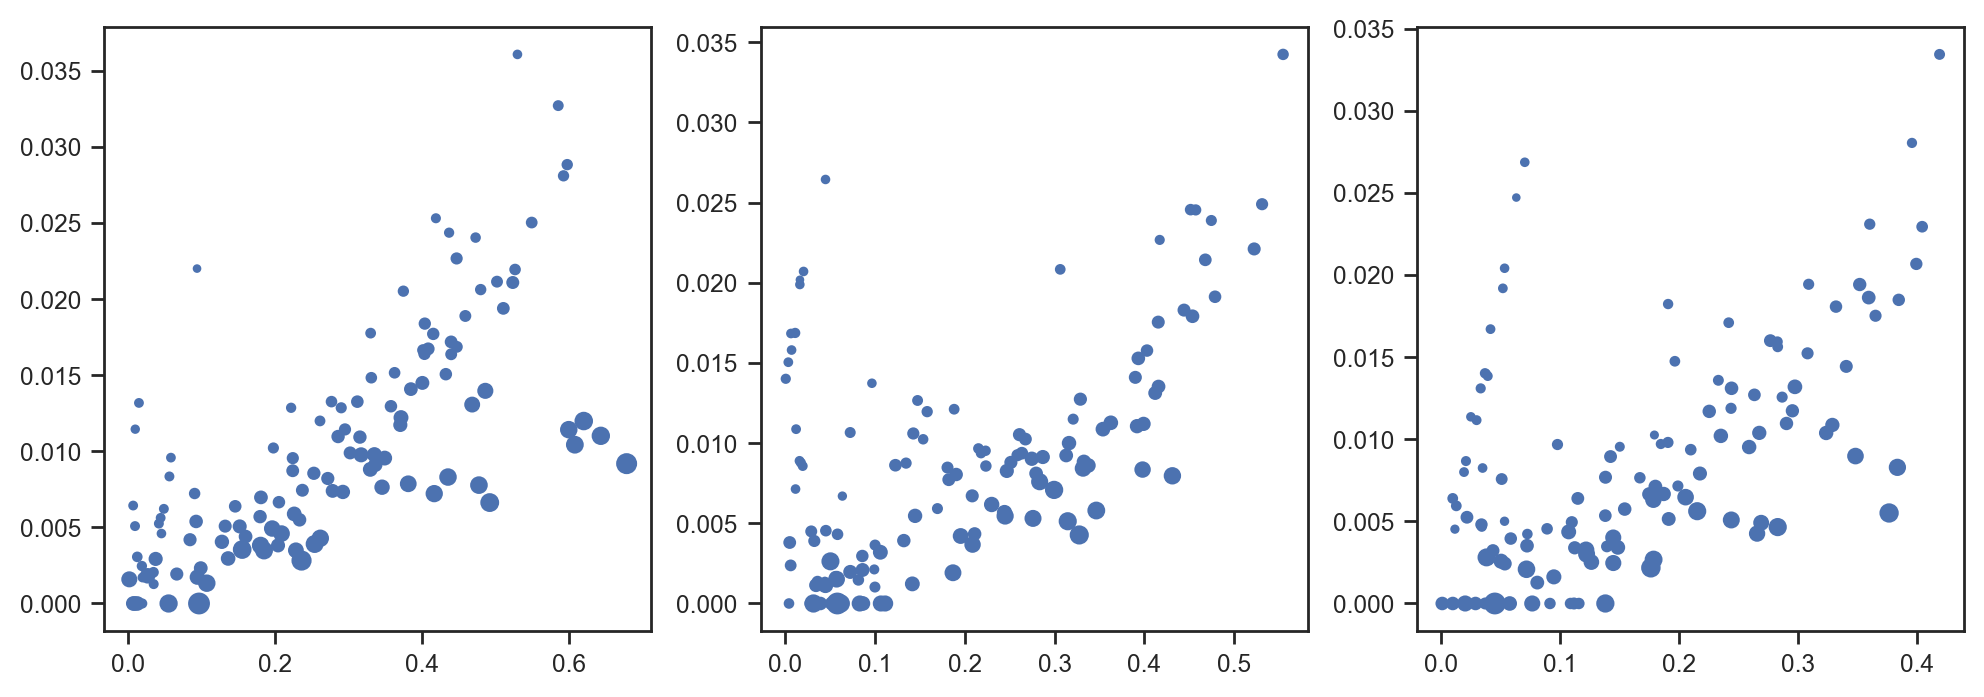

In [141]:
fig,ax = plt.subplots(nrows=1,ncols=3, figsize=(12,4))

ax[0].scatter(abs(taus_cks), abs(medslopes_cks), s=1/rms_cks)
ax[1].scatter(abs(taus_spocs), abs(medslopes_spocs), s=1/rms_spocs)
ax[2].scatter(abs(taus_berg), abs(medslopes_berg), s=1/rms_berg)


# x = abs(taus_cks)
# y = abs(medslopes_cks)

# texts = [ax[0].text(x[i], y[i], 'Text%s' %i) for i in range(len(x[0:10]))]
# adjust_text(texts)

/Users/tdavid/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:306: RuntimeWarning: invalid value encountered in sqrt
  sigma = np.sqrt(sigsq)


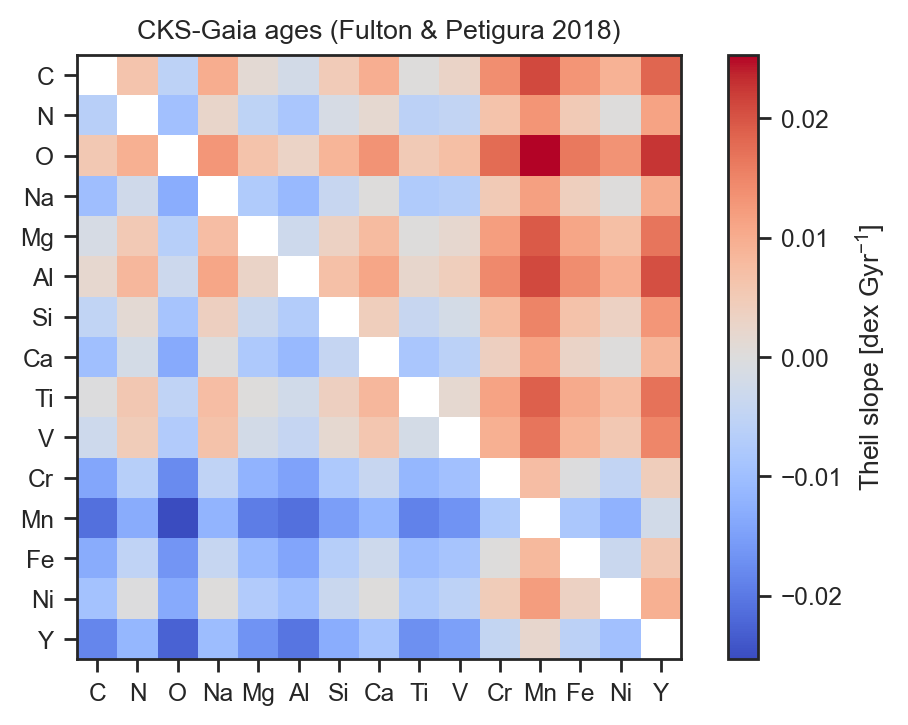

/Users/tdavid/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:306: RuntimeWarning: invalid value encountered in sqrt
  sigma = np.sqrt(sigsq)


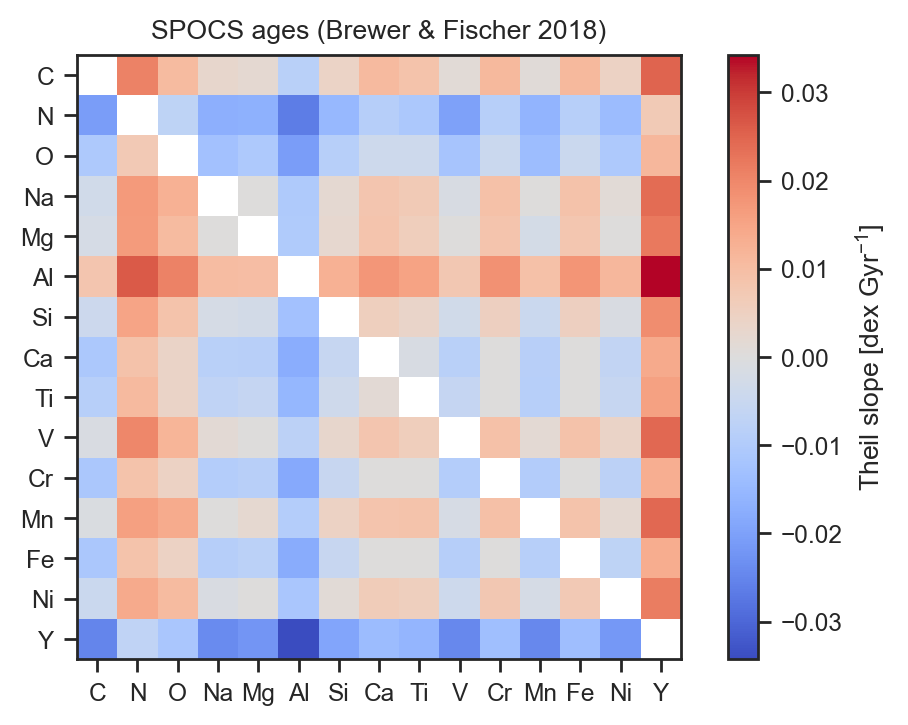

/Users/tdavid/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:306: RuntimeWarning: invalid value encountered in sqrt
  sigma = np.sqrt(sigsq)


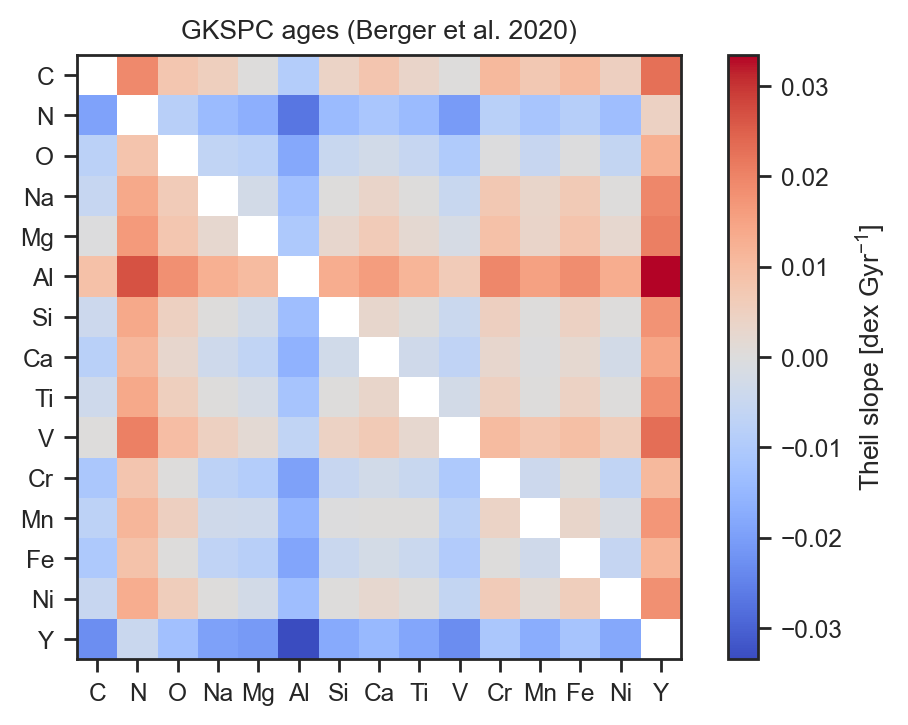

In [26]:
def age_sensitivity_matrix(age_ref='cks', 
                           corr_test='pearson',
                           group=None,
                           fig_path=None):
    
    
    sns.set(style="ticks", context="paper")
    
    teff = df["p20_cks_steff"]
    logg = df["p20_cks_slogg"]
    feh  = df["p20_cks_smet"]
    snr  = df["bf18_S/N"]
    
    
    n20_sun_like = (teff>5600)&(teff<5950)&\
               (logg>4.2) & (logg<4.53)&\
               (feh>-0.3) & (feh<0.3) #& (df['bf18_S/N']>30)
    

    elems = ["C","N","O","Na","Mg","Al","Si","Ca","Ti","V","Cr","Mn","Fe","Ni","Y"]
    c = np.zeros((len(elems),len(elems)))
    p = np.zeros((len(elems),len(elems)))

    if age_ref=='cks':
        age = df['cks_age']
        title = 'CKS-Gaia ages (Fulton & Petigura 2018)'
    elif age_ref=='spocs':
        age = df['bf18_Age']
        title = 'SPOCS ages (Brewer & Fischer 2018)'
    elif age_ref=='berger':
        age = df['b20_iso_age']
        title = 'GKSPC ages (Berger et al. 2020)'
    elif age_ref=='lu':
        age = df['l20_kin_age']
        title = 'Gyro-kinematic ages (Lu et al. 2021)'

    for i in range(len(elems)):
        for j in range(len(elems)):
        
            el1 = elems[i]
            el2 = elems[j]

            x1, e_x1 = df["bf18_["+el1+"/H]"], df["bf18_e_["+el1+"/H]"]
            x2, e_x2 = df["bf18_["+el2+"/H]"], df["bf18_e_["+el2+"/H]"]

            ratio = x1-x2
            mask = (np.isfinite(age)) & (np.isfinite(ratio))
            
            if group is None:
                pass
            
            elif group == 'sunlike':
                mask &= n20_sun_like

            elif group == 'evolved':
                mask &= (logg<4.1)
            
            elif group == 'hotdwarfs':
                mask &= (logg>=4.1) & (teff>=5500)
                
            elif group == 'cooldwarfs':
                mask &= (logg>=4.2) & (teff<5500)                
            
            
            if corr_test == 'pearson':
                coeff,pval = stats.pearsonr(age[mask], ratio[mask])
            elif corr_test == 'spearman':
                coeff,pval = stats.spearmanr(age[mask], ratio[mask])
            elif corr_test == 'kendall':
                coeff,pval = stats.kendalltau(age[mask], ratio[mask])
            elif corr_test == 'theil':
                
                try:
                    res = stats.theilslopes(ratio[mask], age[mask], 0.90)
                    coeff, pval = res[0], 0
                except:
                    coeff, pval = np.nan, 0
            
            c[i,j] = coeff
            p[i,j] = pval
        
        
    c[p>0.001] = np.nan    
        
    sns.set_style("ticks")
    plt.title(title)
    plt.imshow(c, cmap='coolwarm')
    plt.xticks(np.arange(len(elems)), elems)
    plt.yticks(np.arange(len(elems)), elems)
    
    if corr_test == 'theil':
        plt.colorbar(label=r'Theil slope [dex Gyr$^\mathregular{-1}$]')
    else:
        plt.colorbar(label='Correlation coefficient')
        
    if fig_path:
        plt.savefig(fig_path)
    plt.show()
    
    return


age_sensitivity_matrix(age_ref='cks', corr_test='theil', group=None, fig_path='./figures/agematrix-cks.pdf')
age_sensitivity_matrix(age_ref='spocs', corr_test='theil', group=None, fig_path='./figures/agematrix-spocs.pdf')
age_sensitivity_matrix(age_ref='berger', corr_test='theil', group=None, fig_path='./figures/agematrix-berger.pdf')
#age_sensitivity_matrix(age_ref='lu', corr_test='theil', group=None, fig_path='./figures/agematrix-lu.pdf')

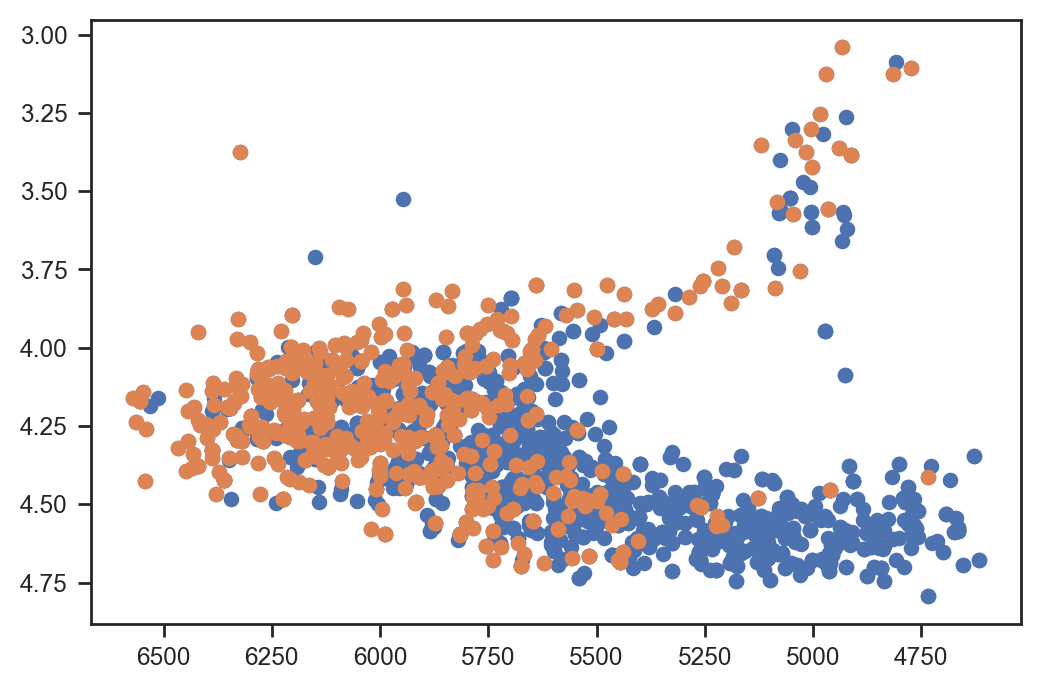

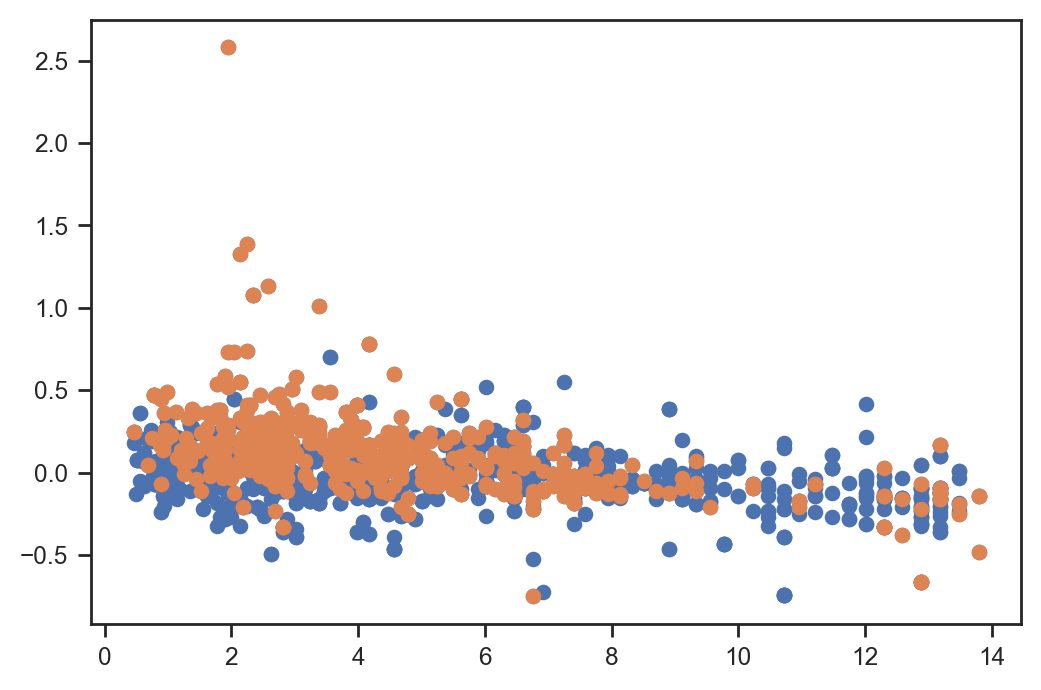

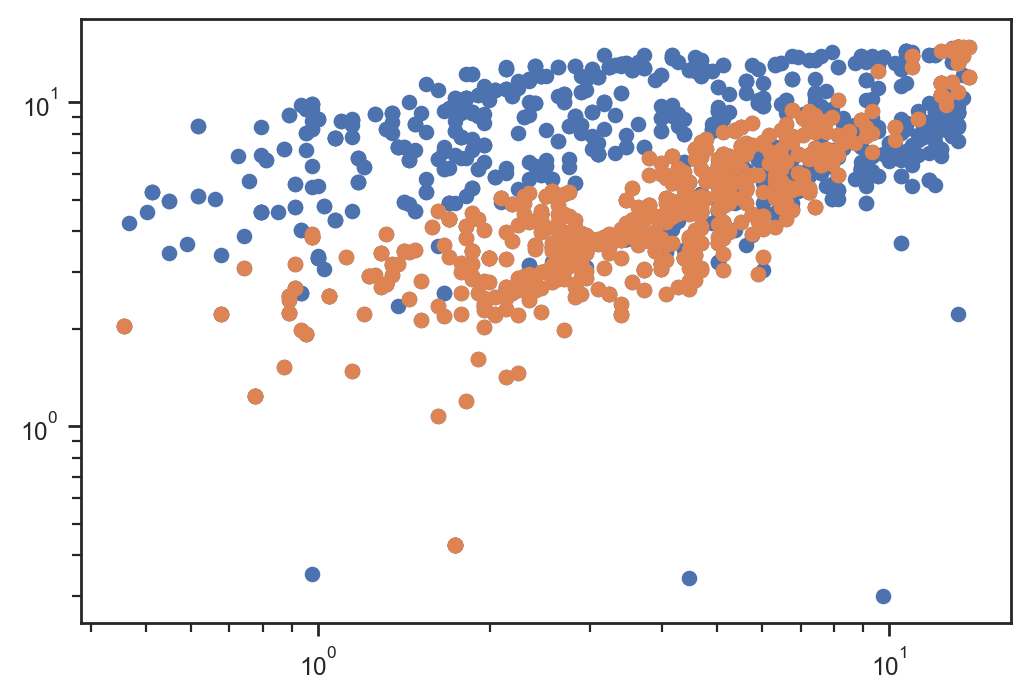

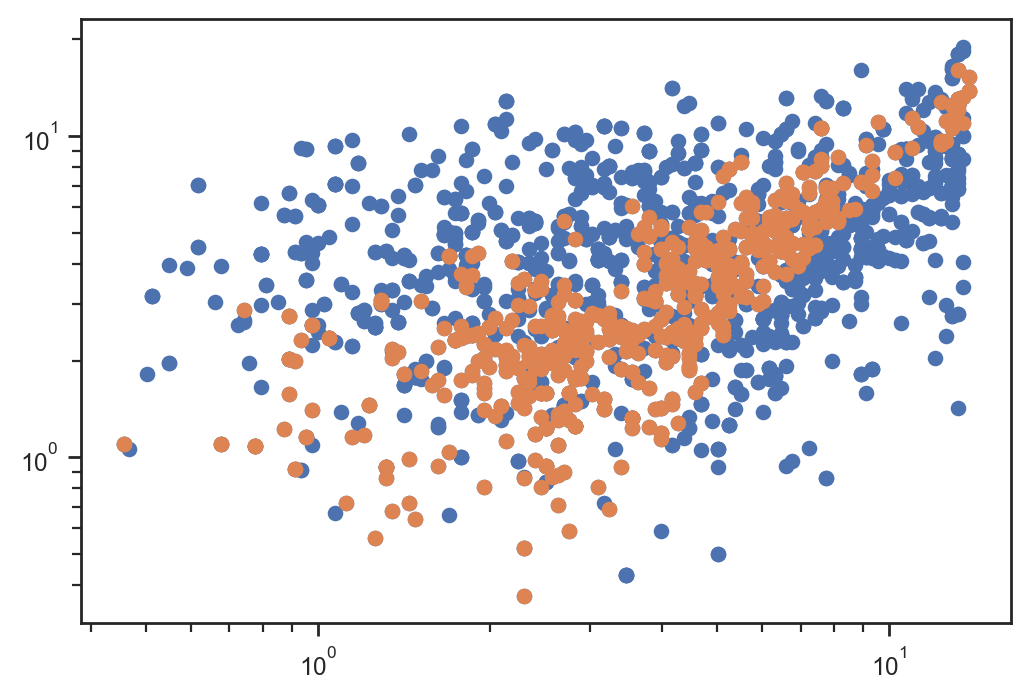

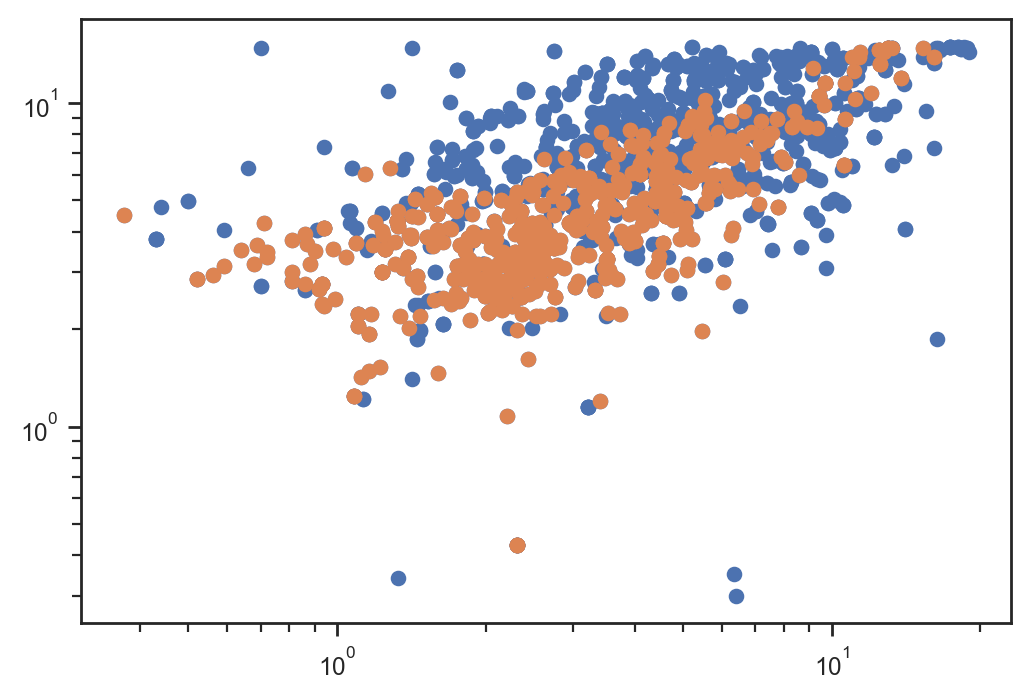

In [108]:
#arg = abs(np.log10(1e9*df["cks_age"])-np.log10(1e9*df["bf18_Age"]))<0.5
arg = abs(df["cks_age"]-df["bf18_Age"])<3
arg &= abs(df["cks_age"]-df["b20_iso_age"])<3

plt.scatter(df['p20_cks_steff'], df['p20_cks_slogg'])
plt.scatter(df['p20_cks_steff'][arg], df['p20_cks_slogg'][arg])
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()
plt.show()

len(df[arg])


plt.scatter(df["cks_age"], df["bf18_[Y/Al]"])
plt.scatter(df["cks_age"][arg], df["bf18_[Y/Al]"][arg])
plt.show()


plt.scatter(df['cks_age'], df['bf18_Age'])
plt.scatter(df['cks_age'][arg], df['bf18_Age'][arg])
plt.loglog()
plt.show()

plt.scatter(df['cks_age'], df['b20_iso_age'])
plt.scatter(df['cks_age'][arg], df['b20_iso_age'][arg])
plt.loglog()
plt.show()


plt.scatter(df['b20_iso_age'], df['bf18_Age'])
plt.scatter(df['b20_iso_age'][arg], df['bf18_Age'][arg])
plt.loglog()
plt.show()